# protyping of basic functions

## to read the csv files we need a function that takes a cabi csv trip data file and returns a dataframe with the data

In [1]:
import pandas as pd
import geopandas as gpd
from os import listdir
import networkx as nx
import matplotlib.pyplot as plt
import osmnx
from shapely.geometry import Point,LineString
from cabi_functions import return_trip_datatable

In [2]:
def load_stations_all():
    df = pd.read_json('https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json')
    datalist = df.iloc[0,0]
    df = pd.DataFrame(datalist)
    df.rename({'short_name':'NAME'},inplace=True)
    stations = df
    geometry = [Point(xy) for xy in zip(stations.lat,stations.lon)]
    gdf = gpd.GeoDataFrame(stations,crs="EPSG:4326", geometry=geometry)
    return gdf

In [3]:
def load_stations():
    df = pd.read_json('https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json')
    datalist = df.iloc[0,0]
    df = pd.DataFrame(datalist)
    df.rename({'short_name':'NAME'},inplace=True)
    stations = df.loc[:,['lon','lat','short_name']]
    geometry = [Point(xy) for xy in zip(stations.lat,stations.lon)]
    gdf = gpd.GeoDataFrame(stations,crs="EPSG:4326", geometry=geometry)
    return gdf

In [205]:
a

,lon,lat,short_name,geometry
0,-77.053230,38.858971,31000,POINT (38.85897 -77.05323)
1,-77.049232,38.856425,31002,POINT (38.85643 -77.04923)
2,-77.049417,38.861056,31003,POINT (38.86106 -77.04942)
3,-77.059490,38.857866,31004,POINT (38.85787 -77.05949)
4,-77.059936,38.862303,31005,POINT (38.86230 -77.05994)
...,...,...,...,...
648,-77.116339,38.857049,31951,POINT (38.85705 -77.11634)
649,-76.996023,38.922404,31531,POINT (38.92240 -76.99602)
650,-77.105564,38.818509,31952,POINT (38.81851 -77.10556)
651,-77.222808,38.878601,32255,POINT (38.87860 -77.22281)


In [206]:
def find_station_geo(stationnum):
    matched = a[a.short_name==stationnum]
    try:
        latval = matched.lat
        lonval = matched.lon
        return (lonval,latval)
    except:
        return None

def make_edge_geometry(start_station_num,end_station_num):
    start_point = find_station_geo(start_station_num)
    end_point = find_station_geo(end_station_num)
    try:
        return LineString((start_point,end_point))
    except: return pd.NA

## using the previously defined external functions we load a pandas dataframe of all 28million cabi trips

In [5]:
station_gdf = load_stations()
# we need a non geopandas verion of this table to avoid a performance penalty due to calls to 
a = pd.DataFrame(station_gdf) 
%time data = return_trip_datatable()

Wall time: 1min 18s


In [6]:
data.dtypes

started_at          datetime64[ns]
ended_at            datetime64[ns]
start_station_id           float64
end_station_id             float64
member_casual               object
dtype: object

In [7]:
reindex = data.set_index(['start_station_id','end_station_id'])

In [8]:
print(data.dtypes)
data.convert_dtypes
print(data.dtypes)

started_at          datetime64[ns]
ended_at            datetime64[ns]
start_station_id           float64
end_station_id             float64
member_casual               object
dtype: object
started_at          datetime64[ns]
ended_at            datetime64[ns]
start_station_id           float64
end_station_id             float64
member_casual               object
dtype: object


In [9]:
triptime = data.ended_at-data.started_at
data = data.assign(triptime=triptime)


<AxesSubplot:xlabel='started_at'>

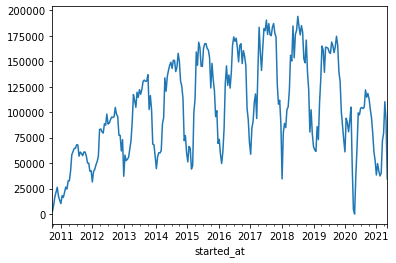

In [10]:
data.set_index('started_at').resample('2W').count().ended_at.plot()

In [11]:
start_end_data = data.loc[:,['start_station_id','end_station_id']].dropna()

In [12]:
route_counts = start_end_data.value_counts()
df_route_counts = pd.DataFrame(route_counts)
df_route_counts = df_route_counts.reset_index().convert_dtypes()
df_route_counts.columns = ['startid','endid','popularity']
popular_routes = df_route_counts[df_route_counts.popularity>0]
popular_routes

,startid,endid,popularity
0,31247,31247,51689
1,31248,31248,44516
2,31258,31249,43765
3,31247,31258,40379
4,31258,31247,36279
...,...,...,...
139152,31901,31303,1
139153,31600,32040,1
139154,31901,31290,1
139155,31600,32048,1


In [13]:
print()
print(popular_routes.popularity.sum()/data.end_station_id.count())


0.998245288284454


In [155]:
# make a shapely geometry for every pair, then return 
#popular_routes = popular_routes.assign(geom = [make_edge_geometry(*coords) for coords in zip(popular_routes.startid,popular_routes.endid)])
# clean out the na values and fix type issues
popular_routes = popular_routes.dropna().convert_dtypes()

# convert the dataframe of routes into a GeoDataframe of edges
# = gpd.GeoDataFrame(popular_routes,crs="EPSG:4326", geometry='geom')
edge_gdf = gpd.read_file('outputs/alltrips_no_self.geojson')

# reproject in epgs 26985 to calculate length
lens = edge_gdf.to_crs(epsg=26985).length
edge_gdf = edge_gdf.assign(length=lens)



In [156]:
def write_no_self_to_file():
    edge_gdf[edge_gdf.startid!=edge_gdf.endid].assign(length = lens).to_crs(epsg=26985).to_file('outputs/alltrips_no_self.geojson',driver='GeoJSON')

In [207]:
sorted_stations = [sorted([int(x),int(y)]) for x,y in zip(edge_gdf.startid,edge_gdf.endid)]
sorted_stations = [int(str(x)+str(y)) for x,y in sorted_stations]
grouped = edge_gdf.assign(sorted_stations=sorted_stations).groupby('sorted_stations')

In [218]:
unidir_routes = grouped.sum().reset_index().sort_values('popularity',ascending=False)
# reassign original station ID
st = [str(x)[:5] for x in unidir_routes.sorted_stations]
end = [str(x)[-5:] for x in unidir_routes.sorted_stations]
unidir_routes = unidir_routes.assign(startid=st,endid=end)
# generate Linestring Geometries from start ID and end ID
geoms = [make_edge_geometry(*coords) for coords in zip(unidir_routes.startid,unidir_routes.endid)]

In [222]:
# make a shapely geometry for every pair, then assigen it to a column called geom 
unidir_routes = unidir_routes.assign(geom = geoms)
# clean out the na values and fix type issues
unidir_routes = unidir_routes.dropna()
# convert the dataframe of routes into a GeoDataframe using the geometry calculated before
unidir_routes = gpd.GeoDataFrame(unidir_routes,crs="EPSG:4326", geometry='geom')


In [223]:
unidir_routes.dtypes

sorted_stations       int64
startid              object
endid                object
popularity            int64
length              float64
geom               geometry
dtype: object

In [225]:
unidir_routes.to_file('outputs/edges_uni.geojson',driver='GeoJSON',)
#edge_gdf.to_file('edges.shp')

In [ ]:
node_gdf = allstation_data.rename({'short_name':'osmid','lat':'x','lon':'y'},axis=1).set_index('osmid',drop=True)
edge_gdf1 = edge_gdf.assign(key=0).assign(length=lens).rename({'startid':'u','endid':'v'},axis=1).set_index(['u','v','key']).sort_values('length',ascending=False)

G = osmnx.utils_graph.graph_from_gdfs(node_gdf,edge_gdf1,)

In [ ]:
colors = osmnx.plot.get_edge_colors_by_attr(G, 'length', num_bins=10, cmap='viridis', start=0, stop=1, na_color='none', equal_size=False)
osmnx.plot_graph(G,edge_color=colors)

In [ ]:
df_lp = edge_gdf[['length','popularity']].copy()

df_lp.plot(kind='scatter',x='length',y='popularity')

edge_gdf.sort_values('length',ascending=False)

In [ ]:
edge_gdf.sort_values('length',ascending=False)

In [ ]:
def undirected_match(df,ID1,ID2):
    a = df.loc[df.start_station_id==ID1 & df.end_station_id==ID2]
    b = df.loc[df.start_station_id==ID2 & df.end_station_id==ID1]
    return pd.concat(a,b)

In [ ]:
a.loc[(a.start_station_id==32219) & (a.end_station_id==31714)]

In [ ]:
def dirtest(a,id1,id2):
    df = pd.concat(
        [
        a.loc[(a.start_station_id==id1) & (a.end_station_id==id2)],
        a.loc[(a.start_station_id==id2) & (a.end_station_id==id1)],
        ]
    ) 
    return df

In [ ]:
longest_ride = dirtest(data,32219,31714)

In [ ]:
longest_ride.dropna(axis=1,)

In [ ]:
data.to_pickle('all_trips_pickle.gz',)


	Duration	started_at	ended_at	start_station_id	start_station_name	end_station_id	end_station_name	Bike number	member_casual	triptime
1087547	11405.0	2017-09-23 11:01:45	2017-09-23 14:11:50	32219.0	Reston YMCA	31714.0	61st St & Banks Pl NE	W20569	Member	0 days 03:10:05
716416	13177.0	2017-08-25 13:13:45	2017-08-25 16:53:23	31714.0	61st St & Banks Pl NE	32219.0	Reston YMCA	W21651	Member	0 days 03:39:38
